In [1]:
import sys
import os
from glob import glob
from pylab import *
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 12,9
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
BJD_2008 = 2454466.500000
EPOINT = 0
np.seterr(invalid='ignore')
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1",
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model",
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")

In [3]:
print("Test")

Test


# A collection of functions

In [14]:
print("Input a .txt file containing the names of the KIC's you want to evaluate. After that, include:\n"+
"For the Energy_vs_frequency analysis:\n'-se': show plots\n'-w' : show the whole plot, including data below ok68 cutoff\n'-ee': include error bars in the plots\n\n"+
"For the Energy_vs_frequency mean-fit analysis:\n'-sm': show plots\n'-em': show error on the plots\n\n"+
"For the Time_vs_fruency analysis:\n'-st': show plots\n\n"+
"Use '-saveplot' to save all of the plots\n"+
"Use '-savefit' to save the fit data\n")


'''if (len(sys.argv)==1):
    print("ERROR: NO TARGET FILE INCLUDED")
    sys.exit()'''

try:
    file = 'KICs/targets4.txt'
    targets = open(file, "r") # a file containing all the KICs we want to plot
except:
    print("\nERROR: Cannot open "+file+".")
    #sys.exit()





'''def check_args(key):
    for x in range(len(sys.argv)-2):
        if sys.argv[x+2]==key:
            return True
    return False'''



def getSize(file):
    '''Returning the number of KICs in a targettext file.

    Parameters
    ----------
    file : string
        The path to the file containing the list of KICs.


    Returns
    -------
    getsize.size : integer
        The number of KICs in the file.
    '''
    temp = pd.read_table(file, names=['kic'])
    getsize = temp['kic'].values
    return getsize.size



def calcChiSq(data, fit, errList):
    '''Caclulate the Chi-Squared value between a fit and the raw data

    Parameters
    ----------
    data : array
        An array of the flare frequency data.

    fit : array
        An array of the fit data

    errList : array
        An array of the error in each fit


    Returns
    -------
    chiSq : float
        the calculated Chi-Square Value
    '''
    chiSq = np.sum(((data - fit) / errList)**2.0)/np.size(data)
    return chiSq



def calcError(data, multiple):
    '''Calculating the asymmetric error bar for each data point

    Parameters
    ----------
    data : array
        An array of the flare frequency data.

    multiple : integer
        The total duration (in days) of each quarter, so that we can get turn the data
        from a #/day unit to a total #, allowing for error bar calculation


    Returns
    -------
    errUp : float
        the upper error bar

    errDn : flaot
        the lower error bar
    '''
    data = data*multiple
    errDn = (np.abs(data * (1.-1./(9. * data)-1./(3.*np.sqrt(data)))**3.-data))/multiple
    errUp = (np.sqrt(data + 0.75) + 1.0)/multiple
    return errUp, errDn





def calcBic(size, degree, chiSq):
    '''Using the Bayesian Information Criterion calculation

    Parameters
    ----------
    size : integer
        The number of data points.
    degree: integer
        The degree of the polynomial fit.
    chiSq : float
        Chi-Squared value.


    Returns
    -------
    bic : float
        the Bayesian Information Criterion Value
    '''
    bic = chiSq + ((degree+1) * np.log(size))
    return bic



def fitDegreeK(xaxis, yaxis, errList, degree, size):
    '''Fitting a polynomial of degree K

    Parameters
    ----------
    xaxis,yaxis : arrays
        The x and y axis values that will be fit.

    errList : array
        The data's associted error bars.

    degree : integer
        The degree of the polynomial to be fit.

    size : integer
        The number of data points.


    Returns
    -------
    bic : float
        The Bayesian Information Criterion value.

    fit : array
        An array containing the best fit of degree k.

    parameters : array
        Coefficients for the fit.

    covariance : matrix (array)
        The covariance matric associated w/ the fit.

    chiSq : float
        The Chi-Squared value.
    '''

    if(degree == 0):
        parameters = [np.mean(yaxis)]
        covariance = np.array([[np.std(yaxis)**2,0],[0,0]])
    else:
        parameters, covariance = np.polyfit(xaxis, yaxis, degree, cov=True, full =False)

    fit = np.polyval(parameters, xaxis)
    chiSq = calcChiSq(yaxis, fit, errList)
    bic = calcBic(size, degree, chiSq)
    return bic, fit, parameters, covariance, chiSq




def updateArray(Fit_Data, targetIndex, KIC, size, degree, bestParameters, bestChiSquare, bestCov):
    '''Updating an array that contain all of the relevant fit data

    Parameters
    ----------
    Fit_Data : array
        The array that will be updated.

    targetIndex : integer
        The index that keeps track of which KIC we're on.

    KIC : string
        The KIC who's data is getting sent to the array.

    size : integer
        Number of data points.

    degree : interger
        The degree of the fit.

    bestParameters : array
        The coefficients of the best fit polynomial.

    bestChiSquare : float
        The Chi-Square of the best fit.

    bestCov : array
        The covariance matrix of the best-fit, returned by polyfit.


    Returns
    -------
    Fit_Data : array
        The array being updated with the fit data, which will eventually be exported (written) to a file
    '''
    Fit_Data[targetIndex, 0] = KIC
    Fit_Data[targetIndex, 1] = size
    Fit_Data[targetIndex,2] = degree
    Fit_Data[targetIndex, 3] = '{}'.format('%.4f'%bestChiSquare)
    length = len(bestParameters)

    for x in range(length):
        Fit_Data[targetIndex, (8-length+x)] = '{}'.format('%.4f'%bestParameters[x])
        Fit_Data[targetIndex, (12-length+x)] = '{}'.format('%.4f'%(np.sqrt(bestCov[x,x])))
    return Fit_Data





def compareFits(xaxis, yaxis, errList):
    '''Comparing two fits, and determining which fit is the 'best' based on the Bayseian information criterion

    Parameters
    ----------
    xaxis,yaxis : arrays
        The x and y axis values that will be fit.

    errList : array
        The error associated with each point

    Returns
    -------
    bestFit : array
        The data from the best fit polynomial.

    bestParameters : array
        The coefficients of polynomial being used to fit the data.

    bestCovariance : array
        A covariance matrix of the bestfit, returned by polyfit

    bestChiSquare : float
        The Chi-Square of the best fit

    bestFitDegree : integer
        The degree of the polynomial being used to fit the data.

    size: integer
        The number of data points in the fit
    '''
    size = np.size(xaxis)
    bestFitDegree = 0
    bic1, bestFit, bestParameters, bestCovariance, bestChiSquare = fitDegreeK(xaxis, yaxis, errList, bestFitDegree, size)
    degree = 1

    while(degree<4):
        try:
            bic2, fit, parameters, covariance, chiSquare = fitDegreeK(xaxis, yaxis, errList, degree, size)
        except:
            break
        if ((bic1 - bic2) >=2):
            bic1, bestFit, bestParameters, bestCovariance, bestChiSquare = bic2, fit, parameters, covariance, chiSquare
            bestFitDegree = degree
            degree+=1
        else:
            break

    return bestFit, bestParameters, bestCovariance, bestChiSquare, bestFitDegree, size



def exp_decay(x, a, c, d):
    return a*10**(-c*x)+d




def plotEVF(KIC, files, fileCount,EVF_Mean_Fit_Data, targetIndex, **kwargs):
    '''Plotting the energy versus frequency for the KIC data

    Parameters
    ----------
    KIC : string
        The KIC being evaluated.

    files : string
        A glob of all of the .flare files, containing the quarters for each KIC.

    fileCount : integer
        The number of files.

    **kwargs
        Show : If True, shows the plots.
        ShowMean : If True, shows the plot associated with subtracting the fit from the mean of each quarter.
        Whole : If True, displays the entire EVF plot, rather than just the plot above the ok68 cutoff.
        Error : If True, shows the error bars on the plot.
    '''
    plt.figure()
    plt.title(str(KIC))
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Log Equivalent Duration")
    plt.yscale('log')
    errListUp = np.array([])
    errListDn = np.array([])
    totalEVFFitX = np.array([])
    totalEVFFitY = np.array([])
    quarterlyEVFX = []
    quarterlyEVFY = []
    meanValues = np.array([])
    time = np.array([])
    print(fileCount)
    for x in range(fileCount):
        toteDuration = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] #getting the total duration of each file
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        print(energy)
        sort = np.argsort(energy) #get indices that would sort the energy array
        ffdXEnergy = np.log10((energy + EPOINT)[sort][::-1])#log the reverse of sorted energy
        ffdYFrequency = (np.arange(1, len(ffdXEnergy)+1, 1))/toteDuration #get evenly spaced intervals, divide by totedur to get flares/day

        ok68 = (ffdXEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT)

        if (any(ok68)):#taking care of the mean-fit data
            quarterlyEVFX.append(ffdXEnergy[ok68])
            quarterlyEVFY.append(ffdYFrequency[ok68])
            time = np.append(time, np.sum(df['t_start'])/len(df['t_start'])) #finding the mean time for a file

        if(kwargs['whole']==True):  #plotting all data
            ok68 = np.isfinite(ffdXEnergy)
        totalEVFFitX = np.append(totalEVFFitX, ffdXEnergy[ok68])
        totalEVFFitY = np.append(totalEVFFitY, ffdYFrequency[ok68])

        plt.plot(ffdXEnergy[ok68], ffdYFrequency[ok68], lw = 1, c = cmap(x/float(len(files))))
        errUp, errDn = calcError(ffdYFrequency[ok68], toteDuration)
        #errup>>errDn
        errListUp = np.append(errListUp, errUp)

        #if(kwargs['errore']==True):
        plt.errorbar(ffdXEnergy[ok68], ffdYFrequency[ok68], yerr = [errDn, errUp], c = 'black', elinewidth=.3, fmt='o', markersize = .55)

    sort = np.argsort(totalEVFFitX)
    #parameters, covariance = np.polyfit(totalEVFFitX, totalEVFFitY, 1, cov=True, full =False)
    #plt.plot(totalEVFFitX[sort], np.polyval(parameters, totalEVFFitX[sort]), lw=4, c='black')
    print(totalEVFFitX[sort])
    print(totalEVFFitY[sort])

    popt, pcov = curve_fit(exp_decay, totalEVFFitX[sort], totalEVFFitY[sort], p0=(.1, .5, .1))#, sigma = errListUp)
    yy = exp_decay(totalEVFFitX[sort], *popt)
    plt.plot(totalEVFFitX[sort], yy, c='black', lw=4)


    if(kwargs['save']==True):
        plt.savefig('energy_vs_frequency_plot/'+ str(KIC) + '_whole_FFD.png')
    if(kwargs['showe']==True):
        plt.show()
    plt.close()

    errListUp = np.array([])
    plt.figure()
    plt.title("Intermediate Plot")
    #fitting a line to the EVF data
    for q in range(len(quarterlyEVFX)):
        #fit = np.polyval(parameters, quarterlyEVFX[q])
        fit = exp_decay(quarterlyEVFX[q], *popt)
        with warnings.catch_warnings(): #RuntimeWarning: Mean of empty slice.
            warnings.simplefilter("ignore", category=RuntimeWarning)
            difference = quarterlyEVFY[q]-fit
            plt.plot(quarterlyEVFX[q], difference, c = cmap(q/float(len(quarterlyEVFX))))
            mean = np.mean(difference)
            meanValues = np.append(meanValues, mean)
            errUp, errDn = calcError(mean, 1)#dealing w/ error
            errListUp = np.append(errListUp,errUp)
    plt.show()
    
    
    
    bestFit, bestParameters, bestCovariance, bestChiSquare, bestFitDegree, size = compareFits(time, meanValues, errListUp)
    plt.figure()
    plt.title(str(KIC))
    plt.ylabel(r'$\sigma$ Per Quarter')
    plt.xlabel("$BJD_{TDB}-2454832$")
    plt.scatter(time,meanValues, c='red')
    plt.plot(time, bestFit, 'black', lw=4)

    EVF_Mean_Fit_Data = updateArray(EVF_Mean_Fit_Data, targetIndex, KIC, size, bestFitDegree, bestParameters, bestChiSquare, bestCovariance)

    if(kwargs['errorm']==True):
        errUp, errDn = calcError(meanValues, 1)
        plt.errorbar(time, meanValues, yerr = [errDn, errUp], c = 'black', elinewidth=.3, fmt='o', markersize = .55)
    if(kwargs['save']==True):
        plt.savefig('time_vs_mean_difference/'+ str(KIC) + '.png')
    if(kwargs['showm']==True):
        plt.show()
    plt.close()

Input a .txt file containing the names of the KIC's you want to evaluate. After that, include:
For the Energy_vs_frequency analysis:
'-se': show plots
'-w' : show the whole plot, including data below ok68 cutoff
'-ee': include error bars in the plots

For the Energy_vs_frequency mean-fit analysis:
'-sm': show plots
'-em': show error on the plots

For the Time_vs_fruency analysis:
'-st': show plots

Use '-saveplot' to save all of the plots
Use '-savefit' to save the fit data



# Plotting energy_vs_frequency for each KIC and time_vs_energy for each KIC/energy combination

0
[]
[]


TypeError: Improper input: N=3 must not exceed M=0

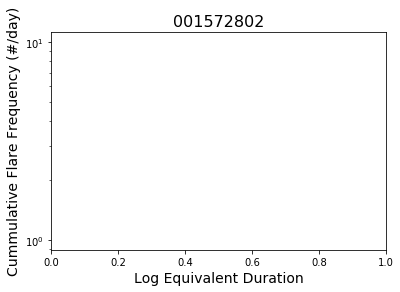

In [15]:
#def main():
targetCount = getSize(file) #getting the number of targets using the target file
evfDir = 'energy_vs_frequency_plot'
tvfDir = 'time_vs_frequency_plot'
TVFfitData = 'TVF_fit_data'
EVFMfitData = 'EVFM_fit_data'
meanFit = 'time_vs_mean_difference'

if not os.path.exists(evfDir): #searching for, and making the directories if they don't exist
    os.makedirs(evfDir)
if not os.path.exists(tvfDir):
    os.makedirs(tvfDir)
if not os.path.exists(TVFfitData):
    os.makedirs(TVFfitData)
if not os.path.exists(EVFMfitData):
    os.makedirs(EVFMfitData)
if not os.path.exists(meanFit):
    os.makedirs(meanFit)

SHOWE = True #check_args("-se")
ERRORE = False #check_args("-ee")
WHOLE = False #check_args("-w")
SHOWM = True #check_args("-sm")
ERRORM = False #check_args("-em")
SHOWT = False #check_args("-st")
SAVEPLOT = False #check_args("-saveplot")
SAVETXT = False #check_args("-savefit")


targets = open(file, "r") # a file containing all the KICs we want to plot
EVF_Mean_Fit_Data = np.zeros((targetCount + 2, 12), dtype='O') #what will become the data file containing all of our EVFMean fit information
EVF_Mean_Fit_Data[0] = ["#This is a file containing the parameters and errors involved in the best fit of a KIC's time vs frequency data",'','','','','','','','','','','']
EVF_Mean_Fit_Data[1] = ["#KIC", 'N', 'best degree', 'chiSquare', 'X^3', 'X^2', 'X^1', 'X^0', 'Error3', 'Error2', 'Error1', 'Error0']
targetIndex = 2

for line in targets: #going through each KIC

    KIC = line.rstrip('\n') #stripping the return off each line
    files = sorted(glob('KICs/'+KIC+"/*.flare")) #Glob all of the files in the directory - get all flares for a star
    fileCount = len(files)
    plotEVF(KIC, files, fileCount, EVF_Mean_Fit_Data,targetIndex, showe=SHOWE,errore=ERRORE,whole=WHOLE,showm=SHOWM,errorm=ERRORM,save=SAVEPLOT)
    targetIndex+= 1

targets.close()
if(SAVETXT==True):
    np.savetxt(EVFMfitData+'/fit_data_for_EVFM.txt', EVF_Mean_Fit_Data, fmt = '% 15s', delimiter=' ', newline='\n', header='', footer='', comments='# ')

In [ ]:
##You've put the error into cruve_fit,finish propogating it through